# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run functions.py

import datetime
import cv2
import os.path
import shutil
from scipy.stats import wilcoxon, pearsonr
from scipy import stats
from scipy.signal import find_peaks
from scipy import ndimage

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Data prep

In [3]:
fn = myProject.dataPath+"/results/cells.csv"
print("Loading", fn)
cells = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/cells.csv


In [4]:
cells=cells[cells.refractoryClean]

In [5]:
fn = myProject.dataPath+"/results/assignment_HDScore.csv"
print("Loading",fn)
dfHDScore = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/assignment_HDScore.csv


In [6]:
fn = myProject.dataPath+"/results/assignment_gridScore.csv"
print("Loading",fn)
dfGridScore = pd.read_csv(fn)
dfGridScore = dfGridScore[dfGridScore.shuffling==False]

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/assignment_gridScore.csv


In [7]:
def getSessionDf(sessionName):
    # Filter cells for the given session
    cellSlice = cells[cells.session == sessionName]

    # Filter myHdStats and dfGridScore for relevant 'cluId' values and conditions
    relevant_hdStats = dfHDScore[(dfHDScore.trialCode == 'circ80_0') & (dfHDScore.cluId.isin(cellSlice.cluId.unique()))]
    relevant_gridScore = dfGridScore[(dfGridScore.trialCode == 'circ80_0') & (dfGridScore.cluId.isin(cellSlice.cluId.unique()))]

    # Merge the filtered dataframes on 'cluId'
    merged_data = pd.merge(cellSlice, relevant_hdStats[['cluId', 'HDScore']], on='cluId', how='left')
    merged_data = pd.merge(merged_data, relevant_gridScore[['cluId', 'gridScore']], on='cluId', how='left')

    # Drop duplicates to avoid repeating cluId entries
    sessionGridScore = merged_data.drop_duplicates(subset='cluId')

    # Select the relevant columns and convert scores to float
    sessionGridScore = sessionGridScore[['cluId', 'HDScore', 'gridScore']].astype({'HDScore': float, 'gridScore': float})

    return sessionGridScore

In [8]:
dfH = []
for ses in useAble:
    testGridHd = getSessionDf(ses)
    dfH.append(testGridHd)

In [9]:
allGridHd = pd.concat(dfH)
allGridHd['session'] = allGridHd['cluId'].apply(lambda x: x.split("_")[0])

In [10]:
fn = myProject.dataPath+"/results/reconstuctionDFOF.csv"
print("Loading", fn)
dfOF = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/reconstuctionDFOF.csv


In [11]:
fn = myProject.dataPath+"/results/sessionList_pathReconstruction.csv"
print("Loading",fn)
sessionNameList = list(pd.read_csv(fn)["session"])

Loading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//results/sessionList_pathReconstruction.csv


In [12]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

def get_mvl_at_speed(df,speed_min=0, speed_max=10):
    vl = vl_mvt_direction_error(df.mvtDirError[(df.speed>speed_min)&(df.speed<speed_max)])
    mid_speed = speed_min+(speed_max-speed_min)/2
    mouse = df.mouse.unique().item()
    res = pd.DataFrame({"vl": [vl],
                 "speed": [mid_speed],
                 "mouse": [mouse]})
    return res 
res = []
for speed in [0, 5,10,15,20,25,30]:
    res.append(dfOF.groupby(["session"]).apply(get_mvl_at_speed,speed,speed+5))

resDf = pd.concat(res).reset_index().drop(columns=["level_1"])

In [13]:
def get_rigid_period(sessionName):
    print(sessionName)
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    #print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in params])
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])

    return np.nanmean(periodRigid)

In [14]:
sesHolder = []
periodHolder = []
for sessionName in sessionNameList:
    sesHolder.append(sessionName)
    periodHolder.append(get_rigid_period(sessionName))

jp486-19032023-0108
jp486-18032023-0108
jp3269-28112022-0108
jp486-16032023-0108
jp452-25112022-0110
jp486-24032023-0108
jp486-22032023-0108
jp452-24112022-0109
jp486-15032023-0108
jp3120-25052022-0107
jp3120-26052022-0107
jp451-28102022-0108
jp486-20032023-0108
jp486-06032023-0108
jp486-26032023-0108
jp486-17032023-0108
jp451-29102022-0108
jp3269-30112022-0110
mn8578-23122021-0108
jp451-30102022-0108
jp3269-27112022-0108
jp486-10032023-0108
jp486-05032023-0108
jp3269-29112022-0108
mn8578-15122021-0107
jp486-13032023-0108
mn8578-17122021-0107
jp3120-24052022-0108
jp452-23112022-0108
jp1686-29042022-0109
jp1687-26052022-0107
jp1686-26042022-0108
jp451-27102022-0108
jp451-01112022-0108
jp1686-28042022-0107
jp3269-26112022-0108
mn8578-25122021-0107
mn8578-05122021-0108
jp486-02032023-0108
mn8578-10122021-0107
jp3129-05062022-0108
jp3129-04062022-0108
jp3120-27052022-0110
jp1084-07042022-0107
mn8578-06122021-0107
jp1084-05042022-0107
jp1687-25052022-0107
jp1686-27042022-0107
mn8599-1102202

In [15]:
sesMedianPeriod = pd.DataFrame({"session":sesHolder,"period":periodHolder})

In [16]:
testDf = resDf.merge(sesMedianPeriod, on="session")

In [17]:
modelPrecisionTest = testDf[testDf.speed==17.5].copy().reset_index()

In [18]:
usedSessionMVL = modelPrecisionTest[modelPrecisionTest.session.isin(useAble)]

In [19]:
percentage_above_threshold = allGridHd[allGridHd.cluId.isin(cells[cells.gridCell_AND].cluId.unique())].groupby('session')['HDScore'].apply(
    lambda x: (x > 0.3).mean() 
).reset_index(name='percentage_hd')


In [20]:
usedSessionMVL = modelPrecisionTest[modelPrecisionTest.session.isin(useAble)]

In [21]:
usedSessionMVL = usedSessionMVL.merge(percentage_above_threshold,on='session')

In [22]:
usedSessionMVL

,index,session,vl,speed,mouse,period,percentage_hd
0,17,jp1686-26042022-0108,0.598247,17.5,jp1686,25.406305,0.125000
1,66,jp3120-25052022-0107,0.690310,17.5,jp3120,35.346695,0.000000
2,73,jp3120-26052022-0107,0.743247,17.5,jp3120,35.232548,0.000000
3,115,jp3269-28112022-0108,0.787585,17.5,jp3269,30.608959,0.000000
4,122,jp3269-29112022-0108,0.448767,17.5,jp3269,29.450092,0.000000
5,150,jp451-28102022-0108,0.666668,17.5,jp451,34.047234,0.071429
6,157,jp451-29102022-0108,0.690769,17.5,jp451,35.294693,0.000000
7,164,jp451-30102022-0108,0.580789,17.5,jp451,34.579250,0.000000
8,171,jp452-23112022-0108,0.486054,17.5,jp452,34.969555,0.000000
9,178,jp452-24112022-0109,0.753335,17.5,jp452,35.977131,0.000000


In [23]:
dfHolder = []
for sessionName in useAble:
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    #print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)

    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])

    gridPeriodDf = pd.DataFrame({'period':periodRigid[:,0],'session':sessionName})
    dfHolder.append(gridPeriodDf)

In [24]:
gridPhaseDf = pd.concat(dfHolder)

In [25]:
gridPhaseDf['mouse'] = gridPhaseDf['session'].apply(lambda x: x.split('-')[0])

In [26]:
bins = np.arange(20, 60, 5)  # 55 is used to include the upper edge of the last bin
gridPhaseDf['period_binned'] = pd.cut(gridPhaseDf['period'], bins=bins, include_lowest=True)

In [27]:
gridPhaseG = gridPhaseDf.groupby(['session', 'period_binned']).size().reset_index(name='count')

In [28]:
gridPhaseG['bin'] = gridPhaseG['period_binned'].apply(lambda x: int(x.right))

In [29]:
heatmap_data = gridPhaseG.pivot_table(values='count', index='session', columns='bin').reset_index(drop=True)

# Make plots

In [30]:
GLOBALFONTSIZE = 13
def plot_hd_grid_score_distribution(ax, testGridHd,title):
    b = sns.scatterplot(data=testGridHd[testGridHd.cluId.isin(cells[cells.gridCell_AND].cluId.unique())],y='HDScore',x='gridScore',color='#ff9f1c',s=15) #,'#2EC4B6'

    ax.set_xlim(0,1.8)
    ax.set_ylim(0,1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Grid score',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('HD selectivity',fontsize=GLOBALFONTSIZE)

    ax.set_title(title,fontsize=GLOBALFONTSIZE)

In [31]:
def plot_hist_hd_score(ax,inputDf):
    sns.histplot(data=inputDf[inputDf.cluId.isin(cells[cells.gridCell_AND].cluId.unique())], y='HDScore', ax=ax,color='#ff9f1c',bins=20,edgecolor='#ff9f1c')
    ax.invert_xaxis()
    ax.set_ylabel('')
    ax.set_xlabel('Count',fontsize=GLOBALFONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [32]:
def plot_hist_grid_score(ax,inputDf):
    sns.histplot(data=inputDf[inputDf.cluId.isin(cells[cells.gridCell_AND].cluId.unique())], x='gridScore', ax=ax,color='#ff9f1c',bins=20,edgecolor='#ff9f1c')
    ax.invert_yaxis()
    ax.set_ylabel('')
    ax.set_xlabel('Count',fontsize=GLOBALFONTSIZE)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [33]:
def plot_conjunctive_hd_grid(ax,usedSessionMVL):

    sns.scatterplot(data=usedSessionMVL, x='percentage_hd', y='vl',s=30, color='#2EC4B6')

    ax.set_ylim(0,1)
    ax.set_ylabel("Direct. precision",fontsize=GLOBALFONTSIZE)

    ax.set_xlim(-0.01,0.2)
    ax.set_xlabel("Percentage of HD cell",fontsize=GLOBALFONTSIZE)
    ax.set_xticks([0,0.1,0.2])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



    print("Pearson correlation, percentage hd cells, pred MVL:")
    r,p = pearsonr(usedSessionMVL["percentage_hd"],usedSessionMVL["vl"])

    ax.text(0.04,0.15, f'R = {round(r,2)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    ax.text(0.04,0.05, f'P-value = {round(p,2)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

    print("N:{}, r:{}, p:{}".format(len(usedSessionMVL["percentage_hd"]),r,p))

# Make figure on grid module

In [34]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('_', ['#12243F','#f4985a', '#b8e9d4'], N=256)

In [35]:
def plot_grid_period(ax,sSes,c= '#FF9F1C'):
    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    #print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)

    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    
    ax.hist(periodRigid[:,0],bins=np.linspace(25,65,40),label="c0-c1-c2",color=c)
    ax.set_xlim(20,50)
    ax.set_xlabel("Grid spacing",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Grid cell count',fontsize=GLOBALFONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


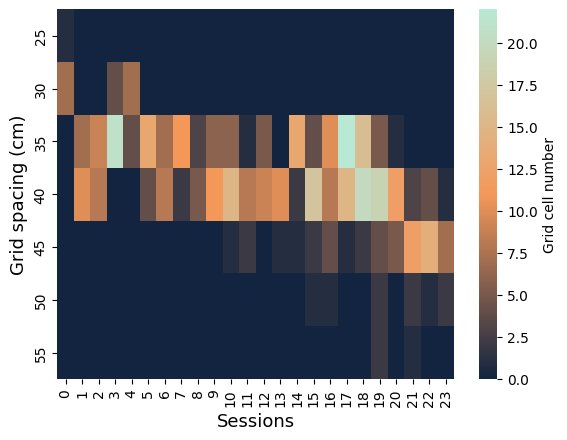

In [36]:
fig, ax =plt.subplots()

def plotGridCellModule(ax, heatmap_data,cmap=cmap):

    b = sns.heatmap(heatmap_data.T, cmap=cmap, ax = ax)

    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Grid cell number')

    ax.set_ylabel('Grid spacing (cm)', fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Sessions', fontsize=GLOBALFONTSIZE)

plotGridCellModule(ax,heatmap_data,cmap)

# Combined figure

In [37]:
def plot_grid_hd_selectivity(inputGs):
    ncols=3
    nrows=3
    gs = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows,width_ratios=[0.4,1,0.01],height_ratios=[1,0.4,1],subplot_spec=inputGs[:,6:])
    gs2 = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1,subplot_spec=gs[2,:2],width_ratios=[0.15,1,0.1])

    def add_text(ax,x,y,label,fw = 'normal'):
        ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+1,
                    verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)


    ax2 = fig.add_subplot(gs[0,1])
    plot_hd_grid_score_distribution(ax2,allGridHd,'')

    ax1 = fig.add_subplot(gs[0,0], sharey=ax2)
    plot_hist_hd_score(ax1,allGridHd)

    ax3 = fig.add_subplot(gs[1,1], sharex=ax2)
    plot_hist_grid_score(ax3,allGridHd)

    ax0 = fig.add_subplot(gs2[0,1])
    plot_conjunctive_hd_grid(ax0, usedSessionMVL)

Pearson correlation, percentage hd cells, pred MVL:
N:24, r:-0.2630481425923897, p:0.21427837768587352


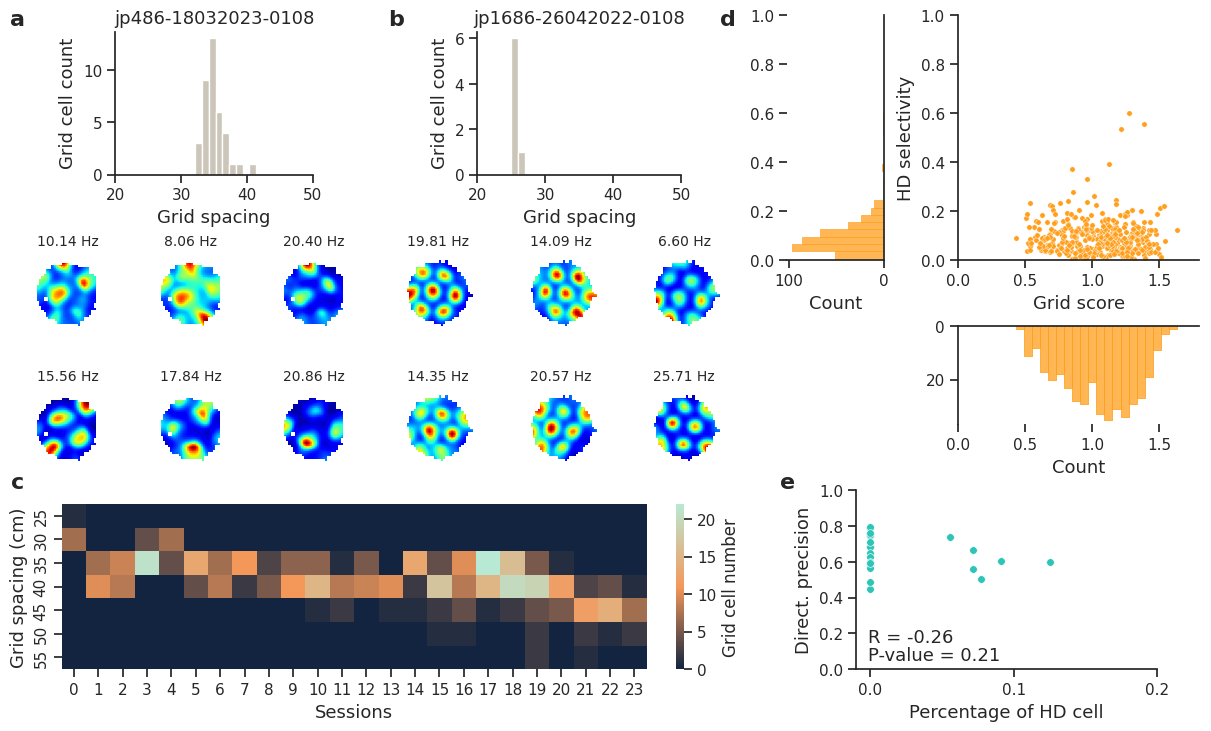

In [38]:
import random

rowSize,colSize= 1.2,1.2
ncols=10
nrows=6
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
sns.set_theme(style = 'ticks')


mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
gs0 = gridspec.GridSpecFromSubplotSpec(1,6,subplot_spec= mainSpec[:2,:3])
gs1 = gridspec.GridSpecFromSubplotSpec(1,6,subplot_spec= mainSpec[:2,3:6])


def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+3,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)



cm_per_bin = 3
xy_range=np.array([[-50,-90],[50,60]])

sSes, ap, apSim, cg = load_session_files_for_modelling('jp486-18032023-0108',cells,sSessions)
firstTrialInter = sSes.trial_intervals.inter[0:1]

ap.set_intervals(firstTrialInter)

ax0 = fig.add_subplot(gs0[0,1:5])
plot_grid_period(ax0,sSes,c= '#ccc5B9')
ax0.set_title(f'{sSes.name}',fontsize=GLOBALFONTSIZE)

random.seed(10)
for n in cg.gc_list:
    n.spike_train.set_intervals(firstTrialInter)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)

for i, n in enumerate(random.sample(cg.gc_list,6)):
    x = int(i/3) + 2
    y = i%3
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))



#Second example
sSes, ap, apSim, cg = load_session_files_for_modelling('jp1686-26042022-0108',cells,sSessions)
firstTrialInter = sSes.trial_intervals.inter[0:1]

ap.set_intervals(firstTrialInter)

ax0 = fig.add_subplot(gs1[0,1:5])
plot_grid_period(ax0,sSes,c= '#ccc5B9')
ax0.set_title(f'{sSes.name}',fontsize=GLOBALFONTSIZE)

for n in cg.gc_list:
    n.spike_train.set_intervals(firstTrialInter)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)

for i, n in enumerate(random.sample(cg.gc_list,6)):
    x = int(i/3) + 2
    y = i%3 + 3
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))

# Heatmap for all sessions
gs2 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= mainSpec[4:,:6])
ax = fig.add_subplot(gs2[:,:])
plotGridCellModule(ax,heatmap_data,cmap)

plot_grid_hd_selectivity(mainSpec)

gsT = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= mainSpec[:,:])
ax0 = fig.add_subplot(gsT[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='bold')
add_text(ax0,0.32,1,'b',fw='bold')
add_text(ax0,0,0.34,'c',fw='bold')
add_text(ax0,0.6,1,'d',fw='bold')
add_text(ax0,0.65,0.34,'e',fw='bold')

ax0.axis('off')

plt.savefig('../../Output/Ext_Figure7.jpg', bbox_inches='tight', dpi=300)